In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import autograd.numpy as np

from plot_tools import plot_contourf, plot_trajectories, plot_cost_function_3d, plot_evolution_charts, plot_cinematics_charts
from matplotlib.animation import FuncAnimation
from optimizers import Optimizer, run_optimizer
from test_optimization_functions import Beale


In [10]:
iterations = 1500
learning_rate = 0.01
cost_f = Beale()

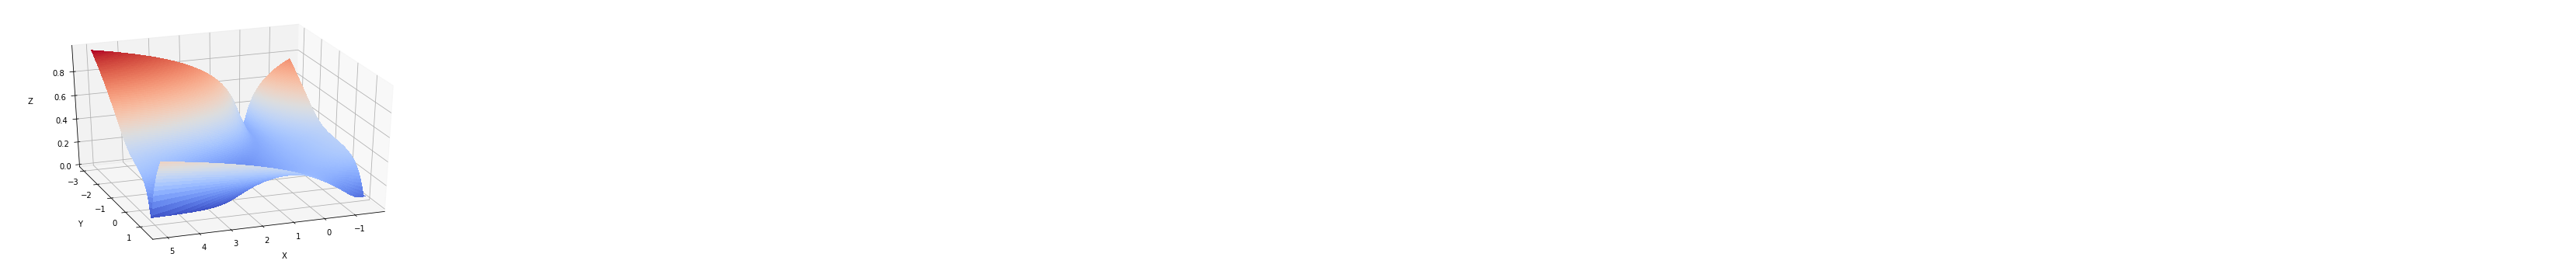

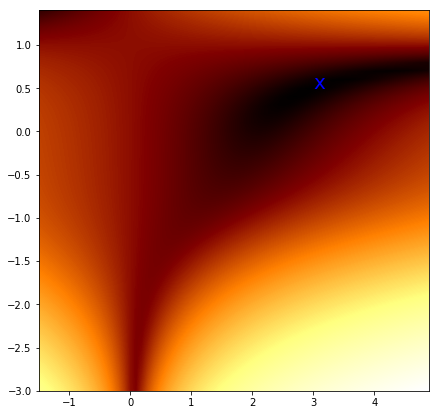

In [11]:
plot_cost_function_3d(cost_f)
plt.show()

plot_contourf(cost_f, figsize=[7,7])
plt.show()